In [1]:
import pandas as pd
import numpy as np
import association_metrics as am
import matplotlib.pyplot as plt
import seaborn as sns

# Bank Market Data

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. Assuming that we are in the middle of the current campaign, the purpose of the analysis is to determine which customers are likely to subscribe to the product so that marketing effort can be prioritised accordingly.

bank-full.csv with 17 inputs, ordered by date.

## Input variables:

### Bank client data:
- age (numeric)
- job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
- marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
- education (categorical: 'tertiary','secondary','primary')
- default: has credit in default? (categorical: 'no','yes')
- housing: has housing loan? (categorical: 'no','yes')
- loan: has personal loan? (categorical: 'no','yes',)

### Related with the last contact of the current campaign:
- contact: contact communication type (categorical: 'cellular','telephone')
- month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
- day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### Other attributes:
- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; -1 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

## Method of Analysis:
1. Tidy data and perform general examination
2. Understanding the data
2. Perform correlation test based on the data pertaining to the previous campaign
3. Analyse data based on all the customers who have said yes in the previous campaign
4. Analyse data based on all the customers who have said yes in the current campaign

### 1. Tidy data and perform general examination 

In [2]:
data = pd.read_csv("bank-full.csv", sep=";")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


From looking at the dataset we decided to change some of the column names to make it a more human-readable.

In [3]:
data.rename(columns={"default":"credit_default",
                     "housing":"housing_loan", "loan":"personal_loan",
                     "contact":"contact_means", "campaign":"no_of_calls",
                     "pdays":"pdaystillnow", "previous":"pnum_calls"}, 
            inplace=True)

We also decided to change all the columns that are yes or no to 0 and 1 to make it easeier for analysis later on

In [4]:
# changing yes to 1 and no to 0
data = data.apply(lambda x: x.map({"yes":1, "no":0}) if set(x.unique())=={"yes","no"} else x)

Also in regard to age and balance we have created 2 extra columns which group them into intervals.

In [5]:
# bin various ages into age groups

bins = [10,20,30,40,50,60,70,80,90,100]
labels = [str(i)+"-"+str(i+9) for i in range(10,100,10)]
data["age_group"] = pd.cut(data["age"], bins=bins, labels=labels, right=False)
                                   

In [6]:
# bin various account balances into balance bins

label_bin = [str(i)+'-'+str(i+9999) for i in range(-10000,100000,10000)]
data['balance_bin'] = pd.cut(x=data.balance, bins=list(np.arange(-10000,110000,10000)),labels=label_bin, right=False) 

In [7]:
data.head()

,age,job,marital,education,credit_default,balance,housing_loan,personal_loan,contact_means,day,month,duration,no_of_calls,pdaystillnow,pnum_calls,poutcome,y,age_group,balance_bin
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0,50-59,0-9999
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0,40-49,0-9999
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0,30-39,0-9999
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0,40-49,0-9999
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0,30-39,0-9999


Rearranging the columns so the categories of age and balance are next to the age and balance columns so as to make it more coherent

In [8]:
data = data[['age',
             'age_group',
             'job',
             'marital',
             'education',
             'credit_default',
             'balance',
             'balance_bin',
             'housing_loan',
             'personal_loan',
             'contact_means',
             'day',
             'month',
             'duration',
             'no_of_calls',
             'pdaystillnow',
             'pnum_calls',
             'poutcome',
             'y']]

### Understanding the data

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             45211 non-null  int64   
 1   age_group       45211 non-null  category
 2   job             45211 non-null  object  
 3   marital         45211 non-null  object  
 4   education       45211 non-null  object  
 5   credit_default  45211 non-null  int64   
 6   balance         45211 non-null  int64   
 7   balance_bin     45210 non-null  category
 8   housing_loan    45211 non-null  int64   
 9   personal_loan   45211 non-null  int64   
 10  contact_means   45211 non-null  object  
 11  day             45211 non-null  int64   
 12  month           45211 non-null  object  
 13  duration        45211 non-null  int64   
 14  no_of_calls     45211 non-null  int64   
 15  pdaystillnow    45211 non-null  int64   
 16  pnum_calls      45211 non-null  int64   
 17  poutcome    

from `.info()` we see we have 45,211 entries of numerical, object and categorical data and now a total of 19 columns

In [10]:
data.describe()[['age','balance']]

,age,balance
count,45211.000000,45211.000000
mean,40.936210,1362.272058
std,10.618762,3044.765829
min,18.000000,-8019.000000
25%,33.000000,72.000000
50%,39.000000,448.000000
75%,48.000000,1428.000000
max,95.000000,102127.000000


As we summarize the data we see that the mean age of the population of the dataset is 40.9 years old and ranges from 18 to 95 with a standard deviation of 10.6 years. The mean balance is €1362.27 that ranges from €-8019 to €102127. 

What is interesting is that the €1428 is the 75th percentile which shows that only 25% of people in the dataset have money above that amount but the max is €102127.

Another anomaly we noticed is that quite a few people have a negative balance, which brings a few questions as to how they would subscribe to a fixed deposit. This makes us think that there is not sufficient information in regards to the balance column and maybe the client has other accounts elsewhere.

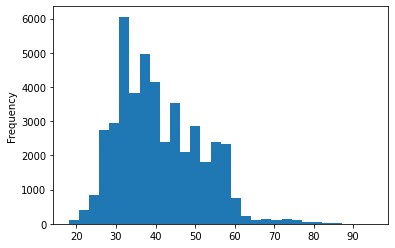

In [11]:
data.age.plot(kind='hist',bins=30);

In [12]:
data.age_group.value_counts()

30-39    18089
40-49    11655
50-59     8410
20-29     5226
60-69     1230
70-79      424
80-89      121
10-19       47
90-99        9
Name: age_group, dtype: int64

As we see most of the population in the dataset fall between the ages of 30-39

In [13]:
data.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

And blue-collar job acount for the majority of jobs (21.5%)

In [14]:
data.education.value_counts()

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64

Secondary education accounts for over 50% of the population of the dataset

In [15]:
# Function to highlight the max an min values in the dataframe
def highlight_max(s):
    return ["background-color:DodgerBlue" if a else " " for a in (s==s.max())]
def highlight_min(s):
    return ["background-color:Red" if a else " " for a in (s==s.min())]

In [16]:
data.groupby('job').mean()[['age','balance']].style.highlight_max(color='lightblue').highlight_min(color='pink')

,age,balance
job,,
admin.,39.289886,1135.838909
blue-collar,40.044081,1078.826654
entrepreneur,42.190989,1521.470074
housemaid,46.415323,1392.395161
management,40.449567,1763.616832
retired,61.626767,1984.215106
self-employed,40.484484,1647.970868
services,38.740250,997.088108
student,26.542644,1388.060768


From grouping the data by jobs we see that that the highest mean age and balance is from the retired people and minimum mean age belongs to the students which makes sense but the minimum mean balance belongs to the service industry.

In [17]:
data.groupby('job').sum()[['credit_default','housing_loan','personal_loan','y']].style.highlight_max(color='lightblue').highlight_min(color='pink')

,credit_default,housing_loan,personal_loan,y
job,,,,
admin.,74,3182,991,631
blue-collar,201,7048,1684,708
entrepreneur,55,869,356,123
housemaid,22,398,152,109
management,164,4678,1253,1301
retired,26,491,309,516
self-employed,33,765,229,187
services,75,2766,836,369
student,3,249,12,269


From changing the yes and no's to 0's and 1's, we were able to group the data by jobs and sum up the 1's to give us the total amount of people who have credit in default, housing loan, personal loan and who have said yes so far.

From this, we are clearly able to see that the blue-collar industry is the industry with the highest amount of people with credit in default, housing loans and personal loans but the people who are in management industry have the most amount of people who have said yes so far.

The unkowns are the minimum in every category.

In [18]:
data.groupby('education').mean()[['age','balance']].style.highlight_max(color='lightblue').highlight_min(color='pink')

,age,balance
education,,
primary,45.865567,1250.949934
secondary,39.964270,1154.880786
tertiary,39.593640,1758.416435
unknown,44.510501,1526.754443


From grouping the data by education we see that people who only have a primary education have the highest mean age. 

Tertiary have the lowest mean age but highest mean balance.

Seconadary have the lowest mean balance.

In [19]:
data.groupby('education').sum()[['credit_default','housing_loan','personal_loan','y']].style.highlight_max(color='lightblue').highlight_min(color='pink')

,credit_default,housing_loan,personal_loan,y
education,,,,
primary,127,3894,1024,591
secondary,458,14038,4303,2450
tertiary,198,6378,1784,1996
unknown,32,820,133,252


From an education point of view we notice that secondary have the most people within all categories.

The unkowns account for the lowest in all categories but primary follows after, also in all categories.

In [20]:
data.groupby('marital').mean()[['age','balance']].style.highlight_max(color='lightblue').highlight_min(color='pink')

,age,balance
marital,,
divorced,45.782984,1178.872287
married,43.408099,1425.925590
single,33.703440,1301.497654


We decided to group by marital status and we see that people who are divorced or widowed hvae the highest mean age but lowest mean balance. 

single people have the lowest mean age and married people have the higest mean balance.

In [21]:
data.groupby('marital').sum()[['credit_default','housing_loan','personal_loan','y']].style.highlight_max(color='lightblue').highlight_min(color='pink')

,credit_default,housing_loan,personal_loan,y
marital,,,,
divorced,128,2907,921,622
married,448,15321,4660,2755
single,239,6902,1663,1912


Married people have the majority in reagrds to every category and divorced or widowed people are the minority.

We want to look at the previous campaign and understand what factors make up a successful subscription.

In [22]:
# checking the number of people who have said yes both in the previous and the current campaigns
data[(data["poutcome"]=="success") & (data["y"]==1)]

,age,age_group,job,marital,education,credit_default,balance,balance_bin,housing_loan,personal_loan,contact_means,day,month,duration,no_of_calls,pdaystillnow,pnum_calls,poutcome,y
24080,56,50-59,technician,married,secondary,0,589,0-9999,1,0,unknown,23,oct,518,1,147,2,success,1
24622,53,50-59,retired,married,tertiary,0,2269,0-9999,0,0,cellular,17,nov,1091,2,150,1,success,1
25555,45,40-49,management,divorced,secondary,0,644,0-9999,1,0,cellular,19,nov,418,1,168,1,success,1
25845,46,40-49,unemployed,divorced,secondary,0,3354,0-9999,1,0,cellular,19,nov,522,1,174,1,success,1
26100,40,40-49,management,married,tertiary,0,3352,0-9999,1,0,cellular,19,nov,639,2,27,1,success,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45190,32,30-39,blue-collar,married,secondary,0,136,0-9999,0,0,cellular,16,nov,206,1,188,3,success,1
45193,28,20-29,self-employed,single,tertiary,0,159,0-9999,0,0,cellular,16,nov,449,2,33,4,success,1
45195,68,60-69,retired,married,secondary,0,1146,0-9999,0,0,cellular,16,nov,212,1,187,6,success,1
45201,53,50-59,management,married,tertiary,0,583,0-9999,0,0,cellular,17,nov,226,1,184,4,success,1


In [23]:
# checking the number of people who have said yes in the previous campaign
success = data[(data["poutcome"]=="success")]
success

,age,age_group,job,marital,education,credit_default,balance,balance_bin,housing_loan,personal_loan,contact_means,day,month,duration,no_of_calls,pdaystillnow,pnum_calls,poutcome,y
24080,56,50-59,technician,married,secondary,0,589,0-9999,1,0,unknown,23,oct,518,1,147,2,success,1
24165,30,30-39,admin.,married,secondary,0,873,0-9999,1,0,telephone,12,nov,119,1,167,3,success,0
24239,48,40-49,admin.,divorced,secondary,0,295,0-9999,1,0,cellular,17,nov,123,1,164,2,success,0
24264,49,40-49,management,married,tertiary,0,64,0-9999,0,0,cellular,17,nov,208,1,159,1,success,0
24435,42,40-49,technician,married,tertiary,0,14282,10000-19999,1,0,cellular,17,nov,77,1,103,4,success,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45190,32,30-39,blue-collar,married,secondary,0,136,0-9999,0,0,cellular,16,nov,206,1,188,3,success,1
45193,28,20-29,self-employed,single,tertiary,0,159,0-9999,0,0,cellular,16,nov,449,2,33,4,success,1
45195,68,60-69,retired,married,secondary,0,1146,0-9999,0,0,cellular,16,nov,212,1,187,6,success,1
45201,53,50-59,management,married,tertiary,0,583,0-9999,0,0,cellular,17,nov,226,1,184,4,success,1


978 customers out of 1511 who said yes to previous campaign have also said yes to the current campaign --> 65% conversion rate --> previous campaign is a pretty good predictor --> we should examine previous campaign to see what variables could help determine the yes outcome.

### 2. Perform correlation test based on the data pertaining to the previous campaign

In [24]:
# looking at columns related to previous campaign
# looking at rows whose poutcome is known (success or failure)

pcampaign_data = data[["age_group","job","marital","education", "credit_default", "balance_bin", "housing_loan","personal_loan","poutcome"]]
pcampaign_data = pcampaign_data[(pcampaign_data["poutcome"]=="success") | (pcampaign_data["poutcome"]=="failure")]

In [25]:
pcampaign_data = pcampaign_data.apply(lambda x: x.astype("category"))

In [26]:
# examining Cramer's V correlation
cramersv = am.CramersV(pcampaign_data)
corr_df = cramersv.fit()
corr_df.loc["poutcome"]

age_group         0.216943
job               0.206495
marital           0.051221
education         0.113036
credit_default    0.035322
balance_bin       0.120127
housing_loan      0.345592
personal_loan     0.129348
poutcome          1.000000
Name: poutcome, dtype: float64

<AxesSubplot:>

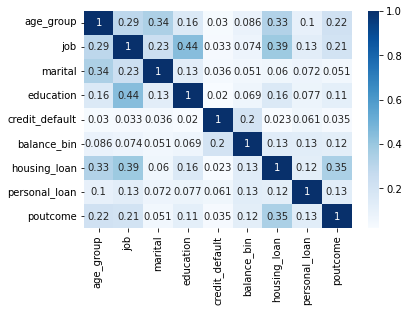

In [27]:
sns.heatmap(corr_df, cmap="Blues", annot=True)

degree of freedom (df) is min(r,c)-1. Since we are only interested in the correlation between poutcome and other variables (because we want to know which variables determine the outcome) and poutcome in pcampaign_data has only two values - "success" or "failure", then df is always 2-1 = 1.

For df=1, 
correlation .10 --> small
correlation .30 --> medium
correlation .50 --> large

Here are the determining factors in order of importance: 
- housing_loan 0.346--> medium correlation
- age_group    0.217--> small-meidum correlation
- job          0.207--> small-medium

- personal_loan 0.129--> small correlation
- balance_bin  0.120--> small correlation
- education    0.113--> small correlation

- martial      0.0512--> small to no correlation 
- credit_default 0.035--> small to no correlation

We will first examine the first three factors with the largest correlation.

### 3. Analyse data based on all the customers who have said yes in the previous campaign

In [28]:
# looking at previous campaign data in relation to people who said yes only.

pcampaign_data = data[["age", "age_group","job","marital","education", "credit_default", "balance", "balance_bin", "housing_loan","personal_loan","poutcome"]]
pcampaign_data = pcampaign_data[(pcampaign_data["poutcome"]=="success") | (pcampaign_data["poutcome"]=="failure")]

pcampaign_said_yes = pcampaign_data[pcampaign_data["poutcome"]=="success"]

`value_counts` is the most relevant analysis here as marketing department would be interested to know from the people who have said yes in the previous campaign, how their age is distributed, how many of them have a housing loan and the types of jobs which all have a small to medium correlation.

`mean`, `max`, `min` would not be relevant for this type of categorical data.

<AxesSubplot:>

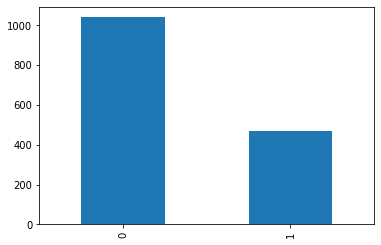

In [29]:
pcampaign_said_yes["housing_loan"].value_counts().plot(kind="bar")

<AxesSubplot:>

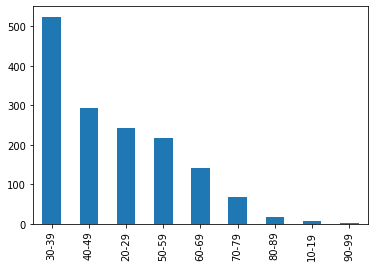

In [30]:
pcampaign_said_yes["age_group"].value_counts().plot(kind="bar")

<AxesSubplot:>

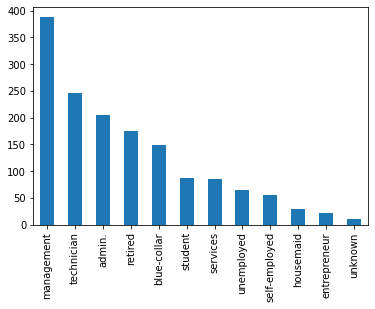

In [31]:
pcampaign_said_yes["job"].value_counts().plot(kind="bar")

<AxesSubplot:xlabel='job'>

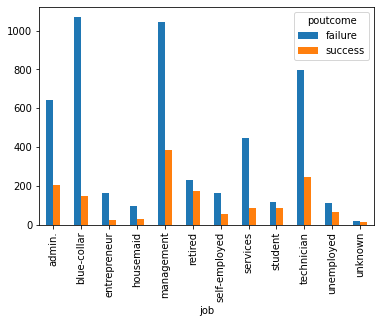

In [32]:
# examining the outcome of previous campaign by profession
cross_job_outcome = pd.crosstab(pcampaign_data.job,pcampaign_data.poutcome)
cross_job_outcome[['failure','success']].plot(kind='bar')

In [33]:
# find summary of balance

pcampaign_said_yes["balance"].describe()

count     1511.000000
mean      1939.301125
std       3725.976363
min       -405.000000
25%        294.000000
50%        920.000000
75%       2316.500000
max      81204.000000
Name: balance, dtype: float64

In [34]:
pcampaign_said_yes["age"].describe()

count    1511.000000
mean       42.964924
std        14.301418
min        18.000000
25%        32.000000
50%        39.000000
75%        53.000000
max        93.000000
Name: age, dtype: float64

In [35]:
pcampaign_said_yes.groupby('job').mean()[['age','balance']]

,age,balance
job,,
admin.,40.029412,1420.803922
blue-collar,38.993243,1351.513514
entrepreneur,47.318182,1909.772727
housemaid,48.758621,1201.689655
management,40.614987,2260.105943
retired,68.856322,2704.816092
self-employed,39.527273,2839.963636
services,39.011765,1143.105882
student,25.977011,1430.344828


<AxesSubplot:xlabel='job'>

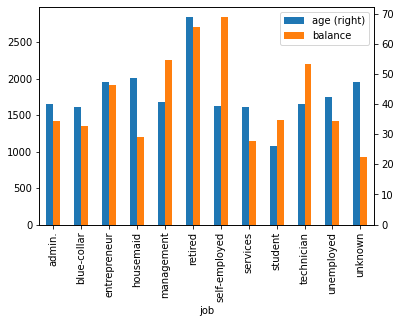

In [36]:
pcampaign_said_yes.groupby('job').mean()[['age','balance']].plot(kind='bar',secondary_y='age')

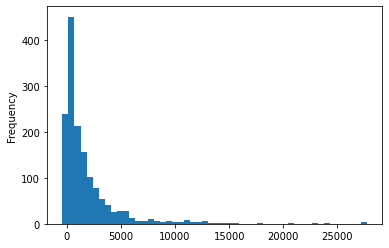

In [37]:
pcampaign_said_yes.balance.sort_values()[:-2].plot(kind='hist',bins=50);

<AxesSubplot:>

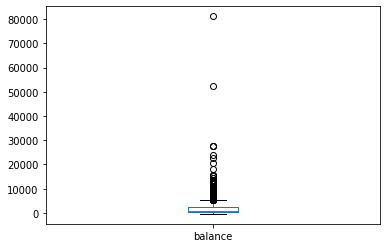

In [38]:
pcampaign_said_yes.balance.plot(kind='box',)

In [39]:
pivot_table = data.pivot_table(index='job',columns='education',values='balance')
pivot_table

education,primary,secondary,tertiary,unknown
job,,,,
admin.,930.478469,1116.059967,1217.777972,1600.742690
blue-collar,1086.104311,1063.894433,1549.248322,1040.850220
entrepreneur,1679.366120,1070.841328,1831.804665,1553.789474
housemaid,1128.261563,1443.589873,1830.416185,2939.333333
management,1672.244898,1326.537021,1833.871170,1634.590909
retired,1879.545912,2061.122967,2161.245902,1503.050420
self-employed,1330.723077,1287.029463,1951.199280,1568.897436
services,966.571014,957.864623,1211.435644,1682.593333
student,1243.522727,1259.903543,1644.923767,1475.073620


In [40]:
pcampaign_said_yes.credit_default.value_counts()

0    1509
1       2
Name: credit_default, dtype: int64

In [41]:
pcampaign_said_yes.housing_loan.value_counts()

0    1040
1     471
Name: housing_loan, dtype: int64

In [42]:
pcampaign_said_yes.personal_loan.value_counts()

0    1429
1      82
Name: personal_loan, dtype: int64

In [43]:
data.age.min()

18

<AxesSubplot:xlabel='age_group,balance_bin'>

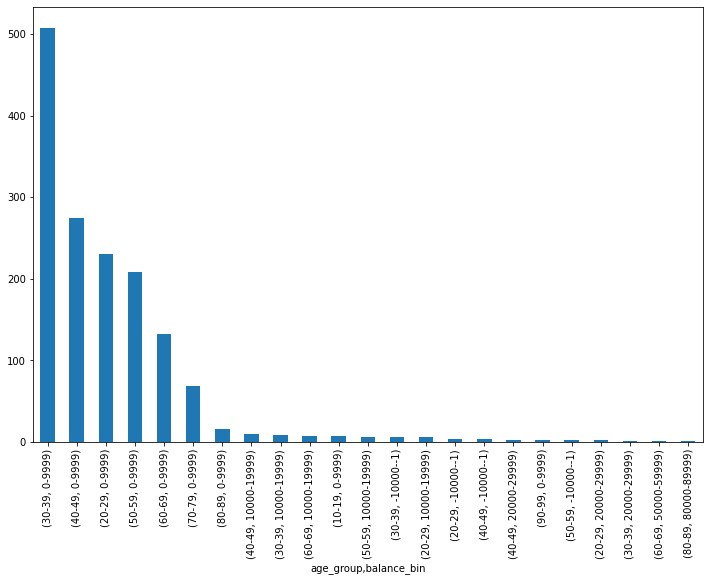

In [44]:
pcampaign_said_yes[['age_group','balance_bin']].value_counts().plot(kind='bar',figsize=(12,8))

From the bar graph above we can clearly see that the most successful categories in regards to age and balance are 30-39 with a balance of €0-€9999

#### Examining the proportion of those who said yes in the previous campaign, by age_group, profession, and housing_loan (variables that show higher correlations) to see which groups show the highest success rate, which should be where the marketing effort is prioritised.

<AxesSubplot:xlabel='age_group'>

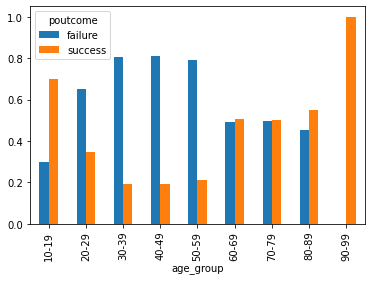

In [45]:
pcampaign_data.groupby(["age_group"])["poutcome"].value_counts(normalize=True).unstack().plot(kind="bar")

The age groups that show higher proportions of success in the previous campaign are 60-69, 70-79, and 80-89 age groups.

Age groups 10-19 and 90-99 show extraordinarily high propotion of success. Upon closer examinations below, it is discovered that the numbers of samples are too low (10 and 3 respectively) to be representative of the gorup.

Nevertheless, age group 90-99 most likely would show similar success rate to age groups 60-69, 70-79, and 80-89 if we had enough samples as the data tends to show that success rate is higher among retired population.

In [46]:
pcampaign_data[pcampaign_data["age_group"]=="10-19"]

,age,age_group,job,marital,education,credit_default,balance,balance_bin,housing_loan,personal_loan,poutcome
40376,19,10-19,student,single,secondary,0,1803,0-9999,0,0,failure
41830,19,10-19,student,single,primary,0,103,0-9999,0,0,success
42274,18,10-19,student,single,primary,0,608,0-9999,0,0,success
42705,19,10-19,student,single,primary,0,103,0-9999,0,0,failure
42954,18,10-19,student,single,unknown,0,108,0-9999,0,0,success
43258,19,10-19,student,single,unknown,0,108,0-9999,0,0,success
43594,19,10-19,student,single,secondary,0,329,0-9999,0,0,success
43680,19,10-19,student,single,primary,0,608,0-9999,0,0,success
44058,19,10-19,student,single,secondary,0,526,0-9999,0,0,failure
44493,19,10-19,student,single,unknown,0,108,0-9999,0,0,success


In [47]:
pcampaign_data[pcampaign_data["age_group"]=="90-99"]

,age,age_group,job,marital,education,credit_default,balance,balance_bin,housing_loan,personal_loan,poutcome
42727,92,90-99,retired,married,unknown,0,775,0-9999,0,0,success
44262,93,90-99,retired,married,unknown,0,775,0-9999,0,0,success
44420,93,90-99,retired,married,unknown,0,775,0-9999,0,0,success


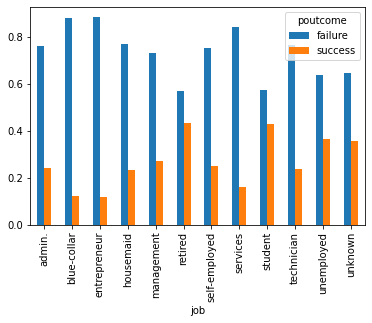

In [48]:
pcampaign_data.groupby(["job"])["poutcome"].value_counts(normalize=True).unstack().plot(kind="bar");

Analysis based on job shows higher success rates in the previous campaign among the following groups: retired, students, unemployed, and unknown.

Result of this analysis based on job coincides with the analysis based on age group - there is higher success rate among older persons of retirement age.  

It is not readily apparent why students, unemployed, and unknown groups show higher success rate in the previous campaign.

<AxesSubplot:xlabel='housing_loan'>

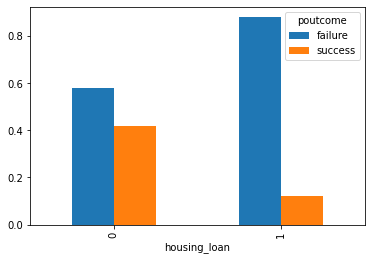

In [49]:
pcampaign_data.groupby(["housing_loan"])["poutcome"].value_counts(normalize=True).unstack().plot(kind="bar")

Analysis based on housing loan clearly shows that extremely high failure rate among those with a housing loan. In contrast, nearly 60% of those without a housing loan result in success in the previous campaign. 

## 4. Analyse data based on all the customers who have said yes in the current campaign

#### A. Analysis of personal data - first on housing_loan, age_group, job, which are the top 3 variables that show small-medium correlation, and then other variables

In [50]:
said_yes = data[data["y"]==1]

In [51]:
said_yes.head()

,age,age_group,job,marital,education,credit_default,balance,balance_bin,housing_loan,personal_loan,contact_means,day,month,duration,no_of_calls,pdaystillnow,pnum_calls,poutcome,y
83,59,50-59,admin.,married,secondary,0,2343,0-9999,1,0,unknown,5,may,1042,1,-1,0,unknown,1
86,56,50-59,admin.,married,secondary,0,45,0-9999,0,0,unknown,5,may,1467,1,-1,0,unknown,1
87,41,40-49,technician,married,secondary,0,1270,0-9999,1,0,unknown,5,may,1389,1,-1,0,unknown,1
129,55,50-59,services,married,secondary,0,2476,0-9999,1,0,unknown,5,may,579,1,-1,0,unknown,1
168,54,50-59,admin.,married,tertiary,0,184,0-9999,0,0,unknown,5,may,673,2,-1,0,unknown,1


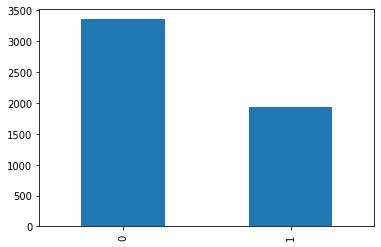

In [52]:
said_yes["housing_loan"].value_counts().plot(kind="bar");

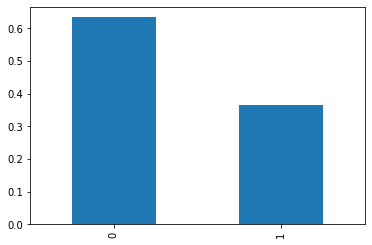

In [53]:
said_yes["housing_loan"].value_counts(normalize=True).plot(kind="bar");

Available data from the current campaign is consistent with the analysis in the previous campaign - those without a housing loan are much more likely to result in success.  

However, the data from the current campaign also shows nearly 2,000 success cases (approximately 35%) among those with housing loan. This means that even though we should prioritise those without a housing loan, we should not exclude whose with a housing loan. 

<AxesSubplot:>

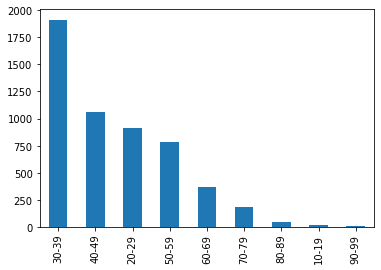

In [54]:
said_yes["age_group"].value_counts().plot(kind="bar")

Analysis based on customers that have said yes in the current campaign show high number of success cases among 30-39, 40-49, 20-29, and 50-59 age groups - seemingly the opposite of the analysis of the previous campaign data. 

However, from the initial review, we already know that these age groups also represent a much larger proportion of customers, meaning that it is logical to expect these age groups to show higher raw number of success cases. These raw numbers do not speak much to the success "rate", which affect the amount of effort (possibly quantified by call duration) required to convert them into success cases.

If we rely on the previous campaign analysis, we should still prioritise the retired age group. After that, we could then work on 30-39, 40-49, 20-29, and 50-59 age groups. And this should result in higher yield in the end within the limited campaign time. 

Note that we cannot yet caluclate the proportion of success/failure among age groups or other variables because the current campaign has not ended.

In [55]:
pd.crosstab(data.job,data.y)


y,0,1
job,,
admin.,4540,631
blue-collar,9024,708
entrepreneur,1364,123
housemaid,1131,109
management,8157,1301
retired,1748,516
self-employed,1392,187
services,3785,369
student,669,269


<AxesSubplot:>

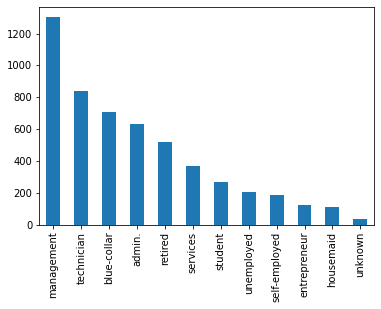

In [56]:
said_yes["job"].value_counts().plot(kind="bar")

As with age_group analysis, the result of the analysis of the current campaign data based on job seems to show opposite of the analysis of the previous campaign data. High number of customers that have said yes in the current campaign are in the following professions: management, technician, blue-collar, and admin, none of which appears as top success predictor based on the old campaign data.

However, from the initial review, we already know that these job groups also represent a much larger proportion of customers, meaning that it is logical to expect these job groups to show higher raw number of success cases as well. These raw numbers do not speak much to the success "rate", which affect the amount of effort (possibly quantified by call duration) required to convert them into success cases.

If we rely on the previous campaign analysis, we should still prioritise these groups: retired, students, unemployed, and unknown. After that, we could then work on management, technician, blue-collar, and admin groups. And this should result in higher yield in the end within the limited campaign time.

Note that we cannot yet caluclate the proportion of success/failure among job groups or other variables because the current campaign has not ended.

<AxesSubplot:xlabel='age_group,balance_bin'>

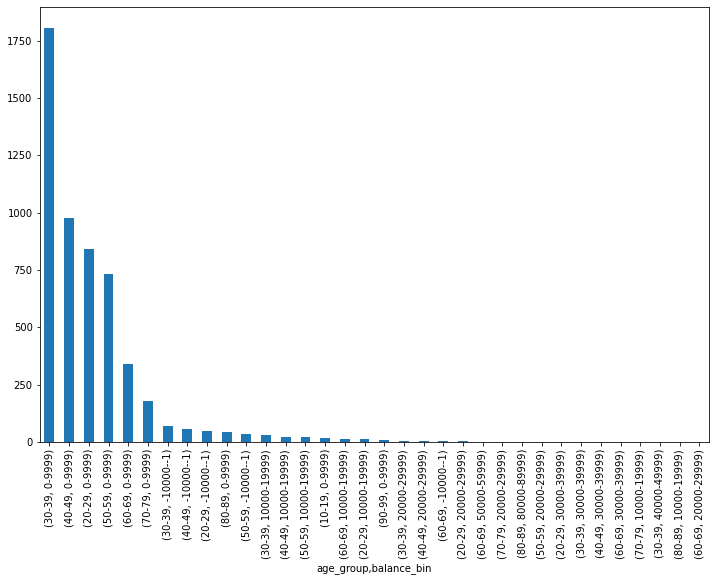

In [57]:
said_yes[['age_group','balance_bin']].value_counts().plot(kind='bar',figsize=(12,8))

#### B. Analysis of call data in this campaign that was not available in previous campaign

In [58]:
said_yes['duration'].min()

8

In [59]:
said_yes[['duration','no_of_calls']].mean()

duration       537.294574
no_of_calls      2.141047
dtype: float64

In [60]:
pcampaign_data["poutcome"].value_counts(normalize=True)

failure    0.764348
success    0.235652
Name: poutcome, dtype: float64

Among those who have said yes in the current campaign, the average number of calls and the duration of each call are 2 calls lasting approximately 537 seconds (or 9 minutes) in each call.  This means that about 18 minutes are required for each success case.  If we rely on the previous campaign overall success rate (0.235), then approximately 76.6 minutes are actually required for one success case (including time spent on failure cases).  

If we know the number of employees in the marketing department available to make calls for the current campaign and the numer of work hours, we could estimate whether the marketing department would need to hire any temp employees to complete the campaign.  

Note that if we better prioritise marketing effort on groups that are likely to be converted into sccuess, then the average 76.6 minutes required for one success case could be significantly reduced.

<AxesSubplot:>

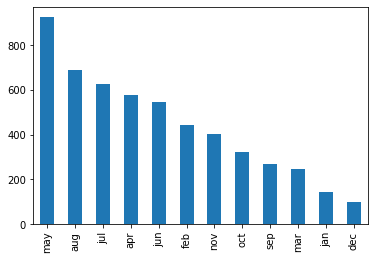

In [61]:
said_yes['month'].value_counts().plot(kind='bar')

<AxesSubplot:>

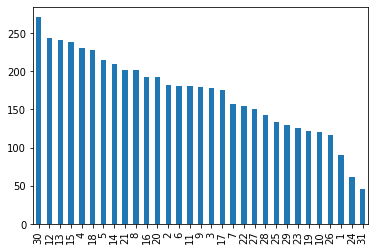

In [62]:
said_yes['day'].value_counts().plot(kind='bar')

Timing seems to play a role in converting customers to a yes in the current campaign. Summer months are yielding more success cases than the non-summer months.

No particular duration of a month seems to matter as the dates with high number of success cases seem to jump from end of the month to the middle to the beginning of the month.

Therefore, more call efforts should be made during the summer months to yield higher success rate.

# Conclusion

1. These groups of customers should be prioritised in order to yield higher success rate:
    - By age group: 60 and over
    - By job: retired, students, unemployed, unknown
    - By housing loan: those without housing loan

2. These groups make up second priority and should not be excluded because they yield significant number of success nonetheless and they also make up a significant proportion of bank customers:
    - By age group: 30-39
    - By job: management and blue-collar
    - By housing loan: those with housing loan

3. The months that yield higher number of success in the current campaign are the summer months.  Therefore, more calls should be made during summer.

4. Each successful conversion requires approximately two calls lasting 9 minutes each.  However, one successful conversion also requires certain amount of time with failure cases.  Therefore one successful conversion actually requires 76.6 minutes in total. This amount of time could be reduced if we better prioritise our effort on the groups are most likely to yield success.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4438a587-cfac-4a8e-9b01-908e88508640' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>